In [1]:
# ! pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

In [2]:
! pip install numba==0.61.0 torchaudio==2.6.0 librosa==0.10.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 48.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 87.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 260.0/260.0 kB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 766.7/766.7 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 100.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 74.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 38.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2

In [3]:
import torch
print(torch.__version__)
print(torch.version.cuda)
print(torch.cuda.is_available())

2.6.0+cu124
12.4
True


In [4]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchaudio
import torchaudio.transforms as T
import numpy as np
import librosa
import librosa.display
import IPython.display as ipd
import torch.nn.functional as F
import matplotlib.pyplot as plt
import json

from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader
from IPython.display import Audio
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Preprocessing data

In [5]:
import numpy as np
import librosa
from sklearn.preprocessing import MinMaxScaler

# lấy 22050 mẫu mỗi giây
def load_and_resample_audio(audio_path, sr=22050):
    y, sr = librosa.load(audio_path, sr=sr)
    return y, sr

# windownwing - Fourier Transform - Mel Filter Bank - Log - DCT
def extract_mfcc(y, sr, n_mfcc=13, n_fft=2048, hop_length=512):
    mfcc = librosa.feature.melspectrogram(
        y, sr, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length)
    return mfcc

def audio_to_melspec(audio, sr, n_mels, n_fft=2048, hop_length=512, to_db=False):
    """
    Chuyển đổi tín hiệu âm thanh thành Mel Spectrogram.

    Parameters:
    - audio: dữ liệu âm thanh đầu vào.
    - sr: tần số lấy mẫu (sampling rate).
    - n_mels: số lượng mel bands.
    - n_fft: độ dài cửa sổ FFT (default=2048). (giống seq_length)
    - hop_length: bước nhảy giữa các cửa sổ FFT (default=512). (giống stride)
    - to_db: có chuyển sang đơn vị decibel (dB) hay không (default=False).

    - overlaps = n_fft - hop_length = 1536 (tiêu chuẩn là hop_length = n_fft/4)
    Returns:
    - spec: Mel Spectrogram dưới dạng ma trận.
    """
    # Tạo Mel spectrogram từ audio input
    spec = librosa.feature.melspectrogram(
        y=audio,
        sr=sr,
        n_fft=n_fft,
        hop_length=hop_length,
        win_length=None,            # Độ dài cửa sổ (mặc định = n_fft)
        window="hann",              # Loại cửa sổ sử dụng để tránh gián đoạn tín hiệu
        center=True,                # Thêm padding vào đầu/cuối tín hiệu
        pad_mode="reflect",         # Kiểu padding
        power=2.0,                  # Bình phương giá trị trong melspectrogram
        n_mels=n_mels               # Số lượng Mel filter
    )

    # Chuyển đổi Mel spectrogram sang đơn vị dB nếu cần
    if to_db:
        spec = librosa.power_to_db(spec, ref=np.max)

    return spec


def normalize_melspec(melspec, norm_range=(0, 1)):
    """
    Chuẩn hóa Mel spectrogram về khoảng giá trị mong muốn (mặc định từ 0 đến 1).
    """
    scaler = MinMaxScaler(feature_range=norm_range)
    melspec = melspec.T  # chuyển vị để chuẩn hóa theo đúng trục thời gian
    melspec_normalized = scaler.fit_transform(melspec)
    return melspec_normalized.T  # chuyển vị lại về dạng ban đầu

def denormalize_melspec(melspec_normalized, original_melspec, norm_range=(0, 1)):
    """
    Khôi phục Mel spectrogram từ dữ liệu đã chuẩn hóa về giá trị gốc.
    """
    scaler = MinMaxScaler(feature_range=norm_range)
    melspec = original_melspec.T  # dùng dữ liệu gốc để lấy lại scale ban đầu
    scaler.fit(melspec)
    melspec_denormalized = scaler.inverse_transform(melspec_normalized.T)
    return melspec_denormalized.T  # chuyển vị lại về dạng ban đầu


def melspec_to_audio(melspec, sr, n_fft=2048, hop_length=512, n_iter=64):
    """
    Chuyển đổi Mel spectrogram về dạng tín hiệu âm thanh.

    Parameters:
    - melspec: Mel spectrogram đầu vào.
    - sr: Tần số lấy mẫu.
    - n_fft: Kích thước FFT.
    - hop_length: Bước nhảy giữa các cửa sổ FFT.
    - n_iter: Số lần lặp của thuật toán Griffin-Lim (để tái tạo phase).

    Returns:
    - audio_reconstructed: Tín hiệu âm thanh được tái tạo từ Mel spectrogram.
    """
    # Chuyển Mel spectrogram từ dB về power nếu có giá trị âm
    if np.any(melspec < 0):
        melspec = librosa.db_to_power(melspec)

    # Chuyển đổi Mel spectrogram thành tín hiệu âm thanh sử dụng thuật toán Griffin-Lim
    audio_reconstructed = librosa.feature.inverse.mel_to_audio(
        melspec,
        sr=sr,
        n_fft=n_fft,
        hop_length=hop_length,
        win_length=None,
        window="hann",
        center=True,
        pad_mode="reflect",
        power=2.0,
        n_iter=n_iter
    )
    return audio_reconstructed


def display_audio_files(reconstructed_audio, sr, title="", original_audio=None):
    """
    Hiển thị âm thanh gốc (nếu có) và âm thanh được tái tạo.

    Parameters:
    - reconstructed_audio: âm thanh tái tạo từ Mel Spectrogram.
    - sr: tần số lấy mẫu của âm thanh.
    - title: tiêu đề hiển thị nếu không có âm thanh gốc.
    - original_audio: âm thanh gốc ban đầu (nếu có).
    """
    if original_audio is not None:
        print("Original Audio:")
        ipd.display(ipd.Audio(original_audio, rate=sr))
        print("Reconstructed Audio (from Mel Spectrogram):")
    else:
        print(title)

    ipd.display(ipd.Audio(reconstructed_audio, rate=sr))


def show_spectrogram(spectrogram, title="Mel-Spectrogram", denormalize=False, is_numpy=False):
    """
    Hiển thị ảnh của Mel Spectrogram.

    Parameters:
    - spectrogram: dữ liệu Mel Spectrogram cần hiển thị.
    - title: tiêu đề của biểu đồ.
    - denormalize: True nếu muốn hiển thị spectrogram đã denormalize.
    - is_numpy: True nếu spectrogram đã là numpy array, False nếu là tensor PyTorch.
    """
    if not is_numpy:
        spectrogram = spectrogram.squeeze().cpu().numpy()

    plt.figure(figsize=(10, 4))

    if denormalize:
        plt.imshow(spectrogram, aspect="auto", origin="lower", cmap="viridis")
    else:
        plt.imshow(spectrogram, aspect="auto", origin="lower",
                   cmap="viridis", vmin=0, vmax=1)

    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Mel Frequency")
    plt.colorbar()
    plt.show()

Audio shape (3022812,)
Mel-Spectrogram shape torch.Size([256, 5904])


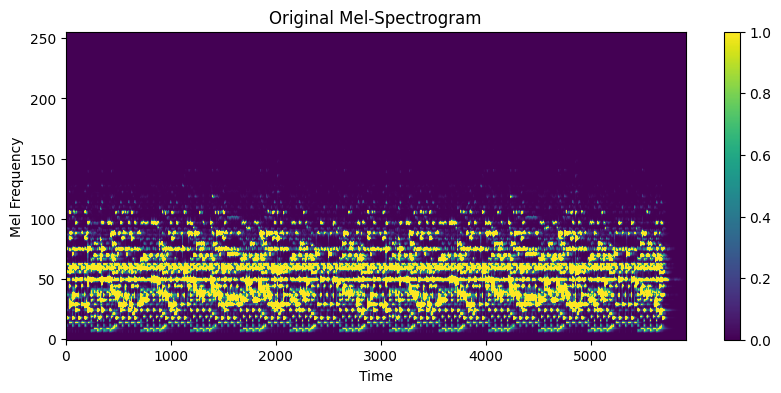

In [6]:
audio, target_sr = load_and_resample_audio('/kaggle/input/aio-music-generation/crawled_data/audio/audio_0001.mp3')
print("Audio shape", audio.shape)
mel_spectrogram = audio_to_melspec(audio, target_sr, n_mels=256)
# 256 tần số, 5904 thời gian
print("Mel-Spectrogram shape", torch.tensor(mel_spectrogram).size())
show_spectrogram(
    mel_spectrogram, title="Original Mel-Spectrogram", is_numpy=True)

In [7]:
def load_and_get_genre_data(data_path):
    with open(data_path, "r") as f:
        data = json.load(f)
    return data.get("genres", [])

def get_id2label_label2id(data_path):
    genres = []
    for audio_file in os.listdir(data_path):
        if not audio_file.endswith(".json"):
            continue
        genres_one_sample = load_and_get_genre_data(os.path.join(data_path, audio_file))
        genres.extend(genres_one_sample)
        genres = list(set(genres))
        id2label = {i: genre for i, genre in enumerate(genres)}
        label2id = {genre: i for i, genre in enumerate(genres)}
    return id2label, label2id

def tokenize_genres(genres, label2id):
    return [label2id[genre] for genre in genres if genre in label2id]

def detokenize_genres(genre_ids, id2label):
    return [id2label[id] for id in genre_ids if id in id2label]

def get_onehot_genres(genre_ids, max_classes):
    onehot = np.zeros(max_classes, dtype=np.float32)
    onehot[genre_ids] = 1
    return onehot

id2label, label2id = get_id2label_label2id('/kaggle/input/aio-music-generation/crawled_data')
print(label2id)
print(id2label)
max_genres = len(id2label)

{'Glitch': 0, 'Holiday': 1, 'Electroacoustic': 2, 'Sound Art': 3, 'Sound Poetry': 4, 'Synth Pop': 5, 'Alternative Hip-Hop': 6, 'Goth': 7, 'House': 8, 'Jazz: Out': 9, 'Dance': 10, 'Singer-Songwriter': 11, 'Drone': 12, 'Sound Collage': 13, 'Comedy': 14, 'Radio': 15, 'Wonky': 16, 'Ambient': 17, 'Improv': 18, 'African': 19, 'Afrobeat': 20, 'Post-Rock': 21, 'Blues': 22, 'Radio Art': 23, 'hiphop': 24, 'Metal': 25, 'Historic': 26, 'Progressive': 27, 'Experimental Pop': 28, 'Avant-Garde': 29, 'New Age': 30, 'Europe': 31, 'Classical': 32, 'Hip-Hop Beats': 33, 'Lo-fi Rock': 34, 'Lo-fi Hip-Hop': 35, 'Jazz': 36, 'Spoken': 37, 'Hip-Hop': 38, 'Big Band/Swing': 39, 'New Wave': 40, 'Novelty': 41, 'Lo-fi Electronic': 42, 'Downtempo': 43, 'Piano': 44, 'Electronic': 45, 'Minimal Electronic': 46, 'Instrumental': 47, 'Nerdcore': 48, 'Easy Listening': 49, 'Vaporwave': 50, 'Indie-Rock': 51, 'Drum & Bass': 52, 'Soul-RnB': 53, 'Mbaqanga': 54, 'Hiplife': 55, 'Tango': 56, 'Lo-fi Soul-RnB': 57, 'Americana': 58, '

## Create dataloader

In [8]:
class AudioDataset(Dataset):
    def __init__(self, audio_path, json_paths, sample_rate, duration, max_genres, n_mels=256, sr=22050, n_fft=2048, hop_length=512, testset_amount=32):
        self.audio_path = audio_path
        self.json_paths = json_paths
        self.label2id = label2id
        self.n_mels = n_mels
        self.sr = sr
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.sample_rate = sample_rate # số mẫu âm thanh mỗi giây
        self.duration = duration # số giây của mỗi audio mình muốn
        self.fixed_length = self.sample_rate * self.duration # số giây mỗi mẫu âm thanh mình muốn
        

        self.audio_files = [audio_file for audio_file in os.listdir(
            audio_path) if audio_file.endswith(".mp3")][:10]
        self.json_files = [json_file for json_file in os.listdir(
            json_paths) if json_file.endswith(".json")][:10]

        audios = []
        for json_file, audio_file in tqdm(zip(self.json_files, self.audio_files), total=len(self.audio_files)):
            #------- genres------------
            genres = load_and_get_genre_data(os.path.join(self.json_paths, json_file))
            genre_ids = tokenize_genres(genres, self.label2id)
            onehot_genres = torch.tensor(get_onehot_genres(
                genre_ids, max_genres)).unsqueeze(0)  # (1, 8)
            
            #------- audio ------------
            print(os.path.join(self.audio_path, audio_file))
            audio, _ = load_and_resample_audio(
                os.path.join(self.audio_path, audio_file))
            n_segments = int(len(audio) / self.fixed_length)
            for i in range(n_segments):
                start = i * self.fixed_length
                end = start + self.fixed_length
                audio_segment = audio[start:end]
                mel_spectrogram = audio_to_melspec(
                    audio_segment, self.sr, n_mels=self.n_mels, n_fft=self.n_fft, hop_length=self.hop_length)
                
                # convert to tensor
                mel_spectrogram_norm = torch.tensor(
                    normalize_melspec(mel_spectrogram)).unsqueeze(0) # (1, 256, 5904) thêm chiều C
                mel_spectrogram = torch.tensor(mel_spectrogram).unsqueeze(0) # (1, 256, 5904) thêm chiều C
                audios.append(
                    (mel_spectrogram_norm, onehot_genres, mel_spectrogram))
                
        self.audios = audios[:len(audios) - testset_amount]
        self.testset = audios[len(audios) - testset_amount:]
        
    def __len__(self):
        return len(self.audios)

    def __getitem__(self, idx):
        mel_spectrogram_norm, onehot_genres, mel_spectrogram = self.audios[idx]
        return mel_spectrogram_norm, onehot_genres, mel_spectrogram
    

In [9]:
import os
from torch.utils.data import DataLoader

# Thiết lập các tham số cơ bản
sample_rate = 22050     # Tần số lấy mẫu (mẫu/giây)
duration = 3            # Độ dài đoạn âm thanh (giây)
n_mels = 256            # Số lượng Mel bands
batch_size = 128        # Kích thước batch khi huấn luyện

# Đường dẫn thư mục chứa dữ liệu audio và json
audio_dir = '/kaggle/input/aio-music-generation/crawled_data/audio'
json_dir = '/kaggle/input/aio-music-generation/crawled_data'

# Số lượng mẫu trong tập test
testset_amount = 1

# Khởi tạo tập dữ liệu trainset và testset từ lớp AudioDataset
trainset = AudioDataset(audio_dir, json_dir, sample_rate, duration, max_genres,
                        n_mels, testset_amount=testset_amount)

testset = trainset.testset

# Kiểm tra nếu không tìm thấy file âm thanh
if len(trainset) == 0:
    raise ValueError(f"No .wav file found in {audio_dir}.")

# Khởi tạo DataLoader cho trainset và testset
trainloader = DataLoader(trainset, batch_size=batch_size,
                         shuffle=True,)
testloader = DataLoader(testset, batch_size=testset_amount,
                        shuffle=False,)

  0%|          | 0/10 [00:00<?, ?it/s]

/kaggle/input/aio-music-generation/crawled_data/audio/audio_0632.mp3


 10%|█         | 1/10 [00:00<00:07,  1.13it/s]

/kaggle/input/aio-music-generation/crawled_data/audio/audio_0411.mp3


 20%|██        | 2/10 [00:01<00:07,  1.09it/s]

/kaggle/input/aio-music-generation/crawled_data/audio/audio_0631.mp3


 30%|███       | 3/10 [00:02<00:05,  1.20it/s]

/kaggle/input/aio-music-generation/crawled_data/audio/audio_0282.mp3


 40%|████      | 4/10 [00:03<00:04,  1.24it/s]

/kaggle/input/aio-music-generation/crawled_data/audio/audio_0726.mp3


 50%|█████     | 5/10 [00:04<00:04,  1.16it/s]

/kaggle/input/aio-music-generation/crawled_data/audio/audio_0541.mp3


 60%|██████    | 6/10 [00:05<00:03,  1.06it/s]

/kaggle/input/aio-music-generation/crawled_data/audio/audio_0236.mp3


 70%|███████   | 7/10 [00:06<00:03,  1.11s/it]

/kaggle/input/aio-music-generation/crawled_data/audio/audio_0709.mp3


 80%|████████  | 8/10 [00:07<00:02,  1.04s/it]

/kaggle/input/aio-music-generation/crawled_data/audio/audio_0012.mp3


 90%|█████████ | 9/10 [00:09<00:01,  1.25s/it]

/kaggle/input/aio-music-generation/crawled_data/audio/audio_0143.mp3


100%|██████████| 10/10 [00:10<00:00,  1.08s/it]


In [10]:
# Lấy một batch từ trainloader để kiểm tra
data_iter = iter(trainloader)
data_batch, genres_batch, original_audio_batch = next(data_iter)

# Hiển thị thông tin về batch
print(f"Shape của batch dữ liệu: {data_batch.shape}")
print(f"Shape của genres: {genres_batch.shape}")
print(f"Shape của audio gốc: {original_audio_batch.shape}")

# Kiểm tra một mẫu dữ liệu cụ thể
sample_index = 0
sample_data = data_batch[sample_index]
sample_genre = genres_batch[sample_index]
sample_original_audio = original_audio_batch[sample_index]

print("\nThông tin mẫu đầu tiên trong batch:")
print(f"- Dữ liệu Mel-Spectrogram shape: {sample_data.shape}")
print(f"- Genres label: {sample_genre}")
print(f"- Original audio shape: {sample_original_audio.shape}")
frame = sample_data[0][0].shape[-1]
print(f"Frame: {frame}")

Shape của batch dữ liệu: torch.Size([128, 1, 256, 130])
Shape của genres: torch.Size([128, 1, 95])
Shape của audio gốc: torch.Size([128, 1, 256, 130])

Thông tin mẫu đầu tiên trong batch:
- Dữ liệu Mel-Spectrogram shape: torch.Size([1, 256, 130])
- Genres label: tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 1., 0., 0.]])
- Original audio shape: torch.Size([1, 256, 130])
Frame: 130


## Code model

In [11]:
class CVAE(nn.Module):
    def __init__(self, d_model, latent_dim, n_frames, n_mels, n_genres):
        super(CVAE, self).__init__()
        self.d_model = d_model
        self.latent_dim = latent_dim
        
        # tính toán trục x và y của mel spectrogram sau khi giảm kích thước 3 lần để khớp với decoder
        self.n_frames = int(np.ceil(n_frames / 2 ** 3)) 
        self.n_mels = int(np.ceil(n_mels / 2 ** 3))

        self.n_genres = n_genres

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1 + self.n_genres, d_model,
                      kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(d_model),
            nn.SiLU(),
            nn.Dropout2d(0.05),

            nn.Conv2d(d_model, d_model * 2,
                      kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(d_model * 2),
            nn.SiLU(),
            nn.Dropout2d(0.1),

            nn.Conv2d(d_model * 2, d_model * 4,
                      kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(d_model * 4),
            nn.SiLU(),
            nn.Dropout2d(0.15),

            nn.AdaptiveAvgPool2d((1, 1)),  # [B, 4*d_model, 1, 1]
            nn.Flatten()
        )

        # Latent space
        self.fc_mu = nn.Linear(d_model * 4, latent_dim)
        self.fc_logvar = nn.Linear(d_model * 4, latent_dim)

        # Decoder
        self.decoder_input = nn.Linear(
            latent_dim + self.n_genres, d_model * 4 * self.n_frames * self.n_mels)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(d_model * 4, d_model * 2, kernel_size=3,
                               stride=2, padding=1, output_padding=(1, 0)),
            nn.BatchNorm2d(d_model * 2),
            nn.SiLU(),
            nn.Dropout2d(0.1),

            nn.ConvTranspose2d(d_model * 2, d_model, kernel_size=3,
                               stride=2, padding=1, output_padding=(1, 0)),
            nn.BatchNorm2d(d_model),
            nn.SiLU(),
            nn.Dropout2d(0.05),

            nn.ConvTranspose2d(d_model, 1, kernel_size=3,
                               stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x, genres_input):
        ori_genres_embed = genres_input.view(genres_input.size(0), -1)
        genres_embed = ori_genres_embed.unsqueeze(-1).unsqueeze(-1) # thêm chiều B, C
        genres_embed = genres_embed.expand(-1, -1, x.size(2), x.size(3))
        x_genres = torch.cat((x, genres_embed), dim=1)

        # ---------------- Encoder ----------------
        h = x_genres
        shortcuts = [] # dùng để bổ sung thông tin cho decoder
        for block in self.encoder:
            h = block(h)
            if isinstance(block, nn.SiLU):
                shortcuts.append(h)

        # ---------------- Latent space ----------------
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)

        z = self.reparameterize(mu, logvar)
        z_genres = torch.cat((z, ori_genres_embed), dim=1)

        h_dec = self.decoder_input(z_genres)
        h_dec = h_dec.view(-1, self.d_model * 4, self.n_frames, self.n_mels)

        # ---------------- Decoder ----------------
        for block in self.decoder:
            if isinstance(block, nn.ConvTranspose2d) and shortcuts:
                shortcut = shortcuts.pop()
                h_dec = h_dec + shortcut
            h_dec = block(h_dec)

        recon = h_dec[:, :, :x.size(2), :x.size(3)]
        return recon, mu, logvar

In [12]:
# Hàm tính loss của VAE (reconstruction loss + KL divergence)
def loss_function(recon_x, x, mu, logvar):
    # MSE Loss giữa ảnh tái tạo và ảnh gốc
    recon_loss = nn.functional.mse_loss(recon_x, x, reduction="sum")

    # KL Divergence giữa phân phối chuẩn hoá và phân phối latent
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return recon_loss + KLD


In [13]:
# Hàm huấn luyện mô hình CVAE
def train_vae(model, dataloader, optimizer, scheduler, num_epochs, verbose_interval=50):
    model.train()
    losses = []

    for epoch in tqdm(range(num_epochs), desc="Training", unit="epoch"):
        train_loss = 0

        for batch_idx, (data, genres_input, ori_data) in enumerate(dataloader):
            data = data.to(device)
            genres_input = genres_input.to(device)

            optimizer.zero_grad()

            # Forward qua mô hình
            recon, mu, logvar = model(data, genres_input)

            # Tính loss
            loss = loss_function(recon, data, mu, logvar)

            # Lan truyền ngược và cập nhật trọng số
            loss.backward()
            train_loss += loss.item()
            optimizer.step()

        scheduler.step()
        avg_loss = train_loss / len(dataloader.dataset)
        losses.append(avg_loss)

        print(
            f"Epoch {epoch}/{num_epochs}, Loss: {avg_loss:.4f}, Lr: {scheduler.get_last_lr()[0]}")

        # Hiển thị ảnh spectrogram mỗi vài epoch
        if epoch == 0 or (epoch + 1) % verbose_interval == 0:
            data_sample = data[0].detach().cpu()
            recon_sample = recon[0].detach().cpu()
            show_spectrogram(data_sample, title="Original Spectrogram")
            show_spectrogram(recon_sample, title="Reconstructed Spectrogram")

    return mu, logvar, losses

Total number of parameters: 32056001


Training:   0%|          | 0/100 [00:00<?, ?epoch/s]

Epoch 0/100, Loss: 10469.5407, Lr: 0.0002


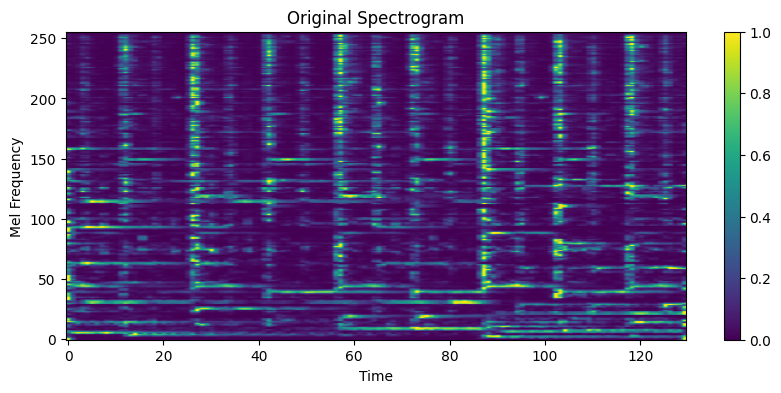

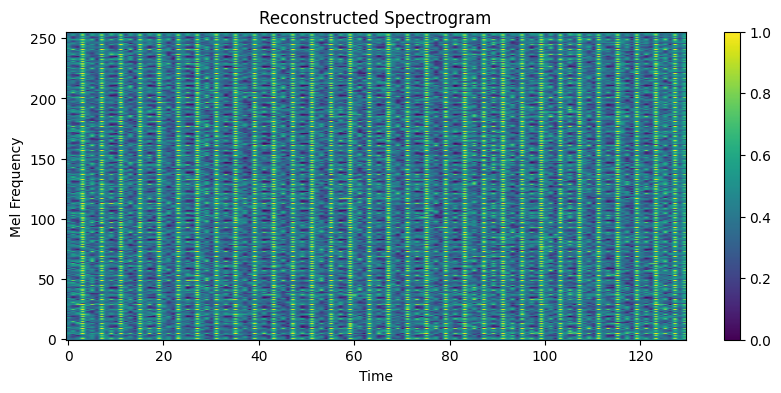

Training:   2%|▏         | 2/100 [00:04<03:39,  2.24s/epoch]

Epoch 1/100, Loss: 7101.0505, Lr: 0.0002


Training:   3%|▎         | 3/100 [00:06<03:16,  2.03s/epoch]

Epoch 2/100, Loss: 5361.6683, Lr: 0.0002


Training:   4%|▍         | 4/100 [00:08<03:04,  1.93s/epoch]

Epoch 3/100, Loss: 4450.3331, Lr: 0.0002


Training:   5%|▌         | 5/100 [00:10<02:58,  1.88s/epoch]

Epoch 4/100, Loss: 3849.2314, Lr: 0.0002


Training:   6%|▌         | 6/100 [00:11<02:53,  1.84s/epoch]

Epoch 5/100, Loss: 3434.3101, Lr: 0.0002


Training:   7%|▋         | 7/100 [00:13<02:49,  1.83s/epoch]

Epoch 6/100, Loss: 3320.8625, Lr: 0.0002


Training:   8%|▊         | 8/100 [00:15<02:46,  1.81s/epoch]

Epoch 7/100, Loss: 3146.5038, Lr: 0.0002


Training:   9%|▉         | 9/100 [00:17<02:44,  1.81s/epoch]

Epoch 8/100, Loss: 3033.4956, Lr: 0.0002
Epoch 9/100, Loss: 2920.5524, Lr: 0.0002


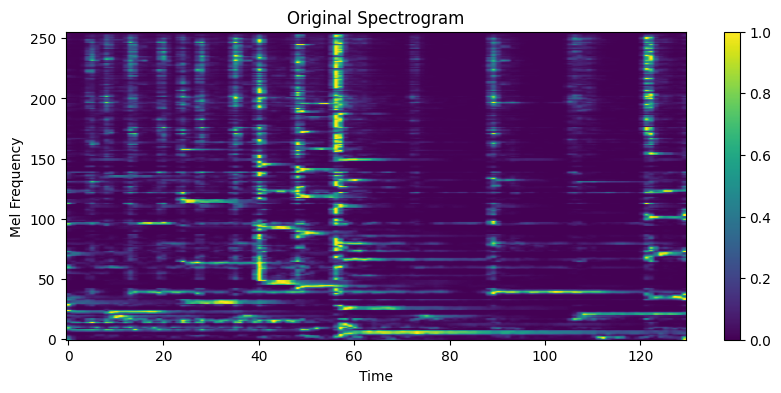

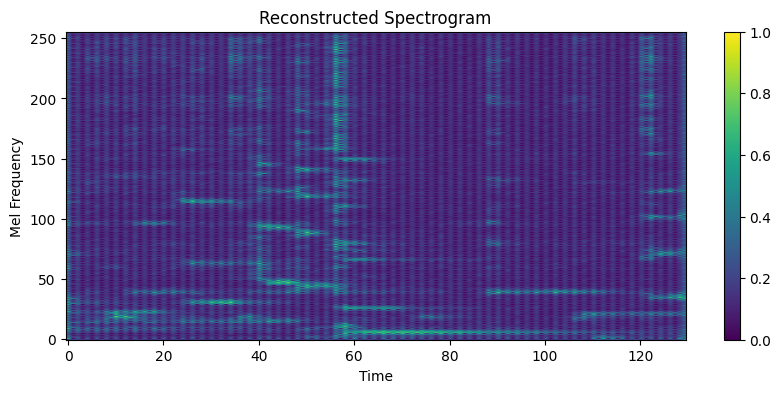

Training:  11%|█         | 11/100 [00:21<02:52,  1.94s/epoch]

Epoch 10/100, Loss: 2848.7243, Lr: 0.0002


Training:  12%|█▏        | 12/100 [00:23<02:46,  1.90s/epoch]

Epoch 11/100, Loss: 2800.5235, Lr: 0.0002


Training:  13%|█▎        | 13/100 [00:25<02:42,  1.87s/epoch]

Epoch 12/100, Loss: 2778.1396, Lr: 0.0002


Training:  14%|█▍        | 14/100 [00:26<02:39,  1.86s/epoch]

Epoch 13/100, Loss: 2688.1082, Lr: 0.0002


Training:  15%|█▌        | 15/100 [00:28<02:37,  1.85s/epoch]

Epoch 14/100, Loss: 2647.6567, Lr: 0.0002


Training:  16%|█▌        | 16/100 [00:30<02:35,  1.85s/epoch]

Epoch 15/100, Loss: 2618.7932, Lr: 0.0002


Training:  17%|█▋        | 17/100 [00:32<02:33,  1.85s/epoch]

Epoch 16/100, Loss: 2578.5739, Lr: 0.0002


Training:  18%|█▊        | 18/100 [00:34<02:31,  1.84s/epoch]

Epoch 17/100, Loss: 2538.4760, Lr: 0.0002


Training:  19%|█▉        | 19/100 [00:36<02:29,  1.84s/epoch]

Epoch 18/100, Loss: 2514.2448, Lr: 0.0002
Epoch 19/100, Loss: 2516.5931, Lr: 0.0002


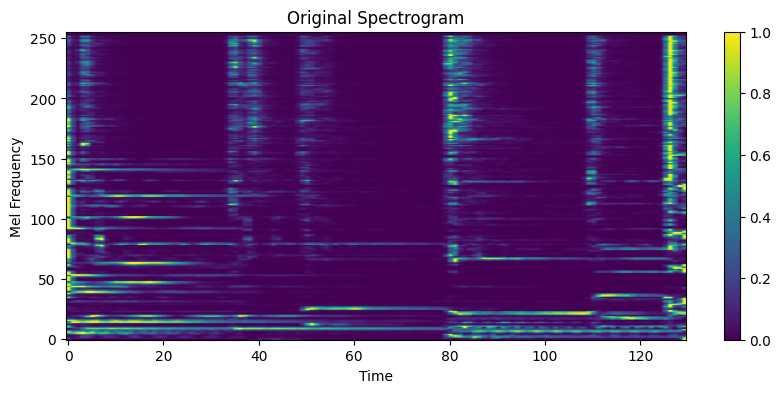

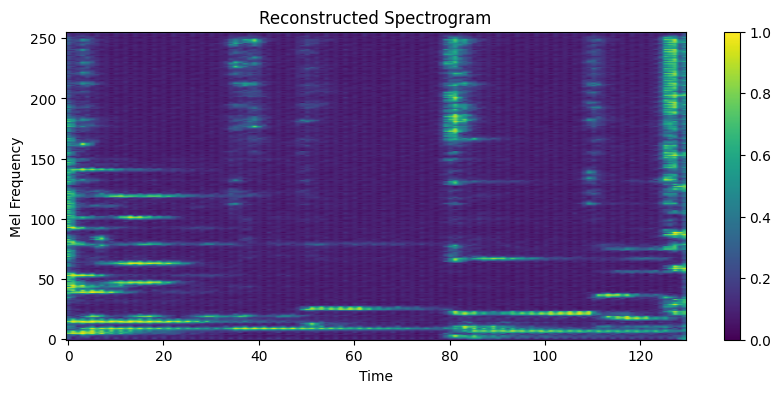

Training:  21%|██        | 21/100 [00:40<02:35,  1.97s/epoch]

Epoch 20/100, Loss: 2498.8105, Lr: 0.0002


Training:  22%|██▏       | 22/100 [00:42<02:30,  1.93s/epoch]

Epoch 21/100, Loss: 2473.9652, Lr: 0.0002


Training:  23%|██▎       | 23/100 [00:44<02:27,  1.91s/epoch]

Epoch 22/100, Loss: 2461.7949, Lr: 0.0002


Training:  24%|██▍       | 24/100 [00:45<02:24,  1.90s/epoch]

Epoch 23/100, Loss: 2438.9847, Lr: 0.0002


Training:  25%|██▌       | 25/100 [00:47<02:21,  1.89s/epoch]

Epoch 24/100, Loss: 2411.5247, Lr: 0.0002


Training:  26%|██▌       | 26/100 [00:49<02:19,  1.89s/epoch]

Epoch 25/100, Loss: 2401.2878, Lr: 0.0002


Training:  27%|██▋       | 27/100 [00:51<02:17,  1.88s/epoch]

Epoch 26/100, Loss: 2394.8139, Lr: 0.0002


Training:  28%|██▊       | 28/100 [00:53<02:15,  1.89s/epoch]

Epoch 27/100, Loss: 2373.1447, Lr: 0.0002


Training:  29%|██▉       | 29/100 [00:55<02:13,  1.89s/epoch]

Epoch 28/100, Loss: 2346.3743, Lr: 0.0002
Epoch 29/100, Loss: 2323.2672, Lr: 0.0002


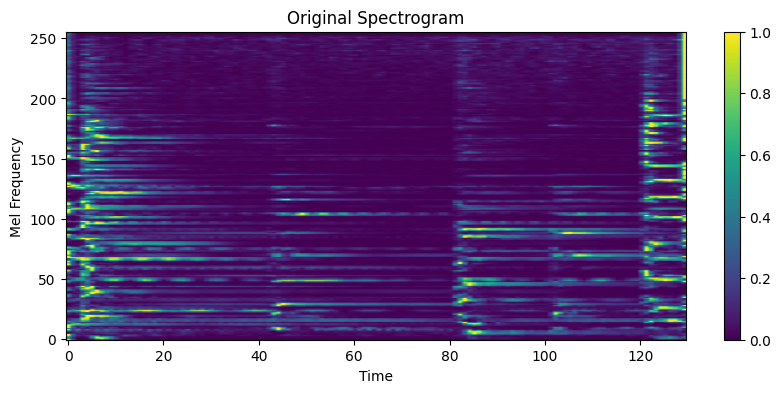

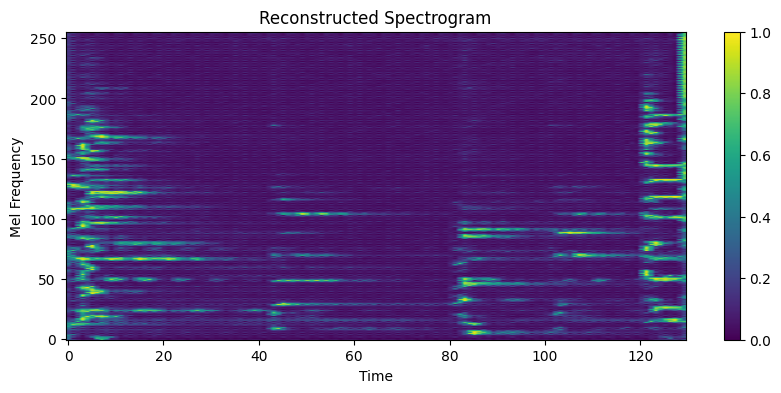

Training:  31%|███       | 31/100 [00:59<02:19,  2.02s/epoch]

Epoch 30/100, Loss: 2320.6413, Lr: 0.0002


Training:  32%|███▏      | 32/100 [01:01<02:14,  1.98s/epoch]

Epoch 31/100, Loss: 2307.9468, Lr: 0.0002


Training:  33%|███▎      | 33/100 [01:03<02:11,  1.96s/epoch]

Epoch 32/100, Loss: 2304.6714, Lr: 0.0002


Training:  34%|███▍      | 34/100 [01:05<02:08,  1.95s/epoch]

Epoch 33/100, Loss: 2309.4613, Lr: 0.0002


Training:  35%|███▌      | 35/100 [01:07<02:06,  1.95s/epoch]

Epoch 34/100, Loss: 2271.7437, Lr: 0.0002


Training:  36%|███▌      | 36/100 [01:09<02:04,  1.95s/epoch]

Epoch 35/100, Loss: 2131.2762, Lr: 0.0002


Training:  37%|███▋      | 37/100 [01:11<02:02,  1.95s/epoch]

Epoch 36/100, Loss: 1885.0852, Lr: 0.0002


Training:  38%|███▊      | 38/100 [01:13<02:00,  1.95s/epoch]

Epoch 37/100, Loss: 1594.3529, Lr: 0.0002


Training:  39%|███▉      | 39/100 [01:15<01:58,  1.94s/epoch]

Epoch 38/100, Loss: 1547.9504, Lr: 0.0002
Epoch 39/100, Loss: 1553.5133, Lr: 0.0002


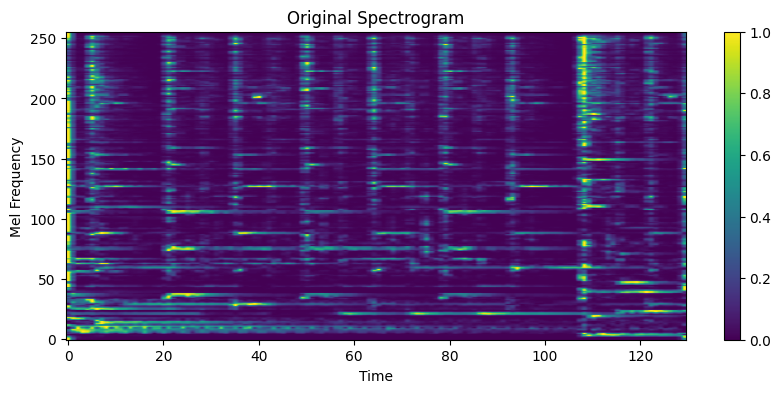

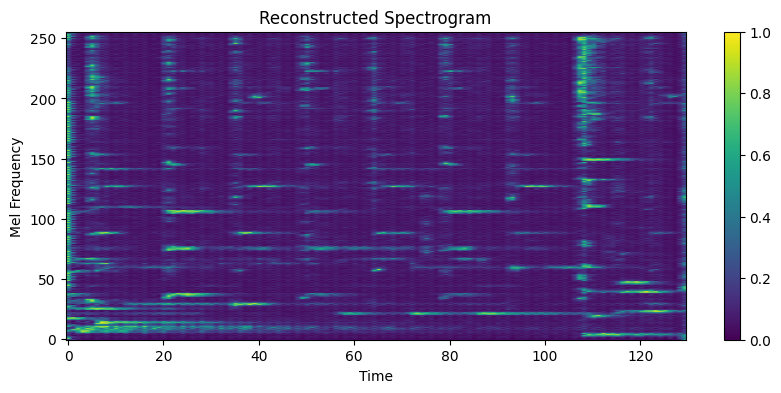

Training:  41%|████      | 41/100 [01:19<02:03,  2.09s/epoch]

Epoch 40/100, Loss: 1516.4121, Lr: 0.0002


Training:  42%|████▏     | 42/100 [01:21<01:58,  2.05s/epoch]

Epoch 41/100, Loss: 1495.5898, Lr: 0.0002


Training:  43%|████▎     | 43/100 [01:23<01:55,  2.03s/epoch]

Epoch 42/100, Loss: 1489.0426, Lr: 0.0002


Training:  44%|████▍     | 44/100 [01:25<01:52,  2.01s/epoch]

Epoch 43/100, Loss: 1493.1309, Lr: 0.0002


Training:  45%|████▌     | 45/100 [01:27<01:50,  2.01s/epoch]

Epoch 44/100, Loss: 1482.3735, Lr: 0.0002


Training:  46%|████▌     | 46/100 [01:29<01:48,  2.01s/epoch]

Epoch 45/100, Loss: 1471.6017, Lr: 0.0002


Training:  47%|████▋     | 47/100 [01:31<01:46,  2.01s/epoch]

Epoch 46/100, Loss: 1468.5702, Lr: 0.0002


Training:  48%|████▊     | 48/100 [01:33<01:44,  2.01s/epoch]

Epoch 47/100, Loss: 1446.4249, Lr: 0.0002


Training:  49%|████▉     | 49/100 [01:35<01:42,  2.01s/epoch]

Epoch 48/100, Loss: 1463.6375, Lr: 0.0002
Epoch 49/100, Loss: 1434.3521, Lr: 0.0001


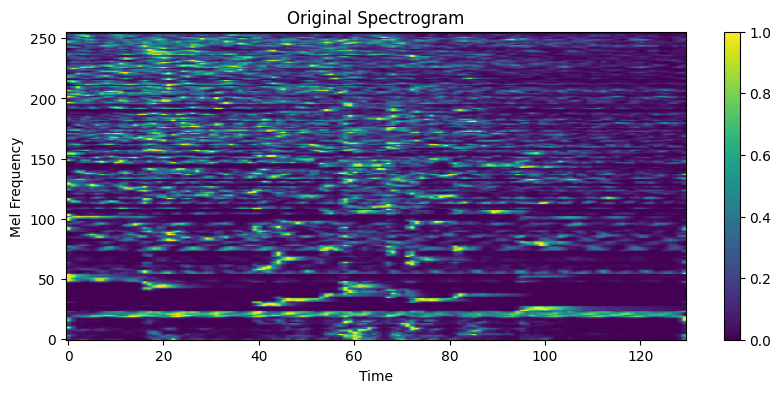

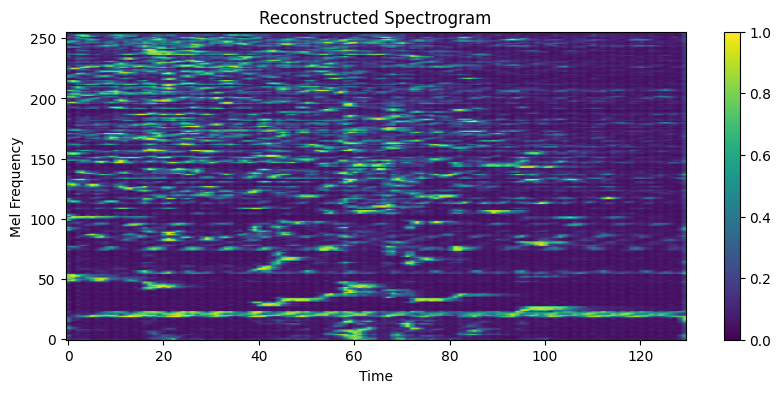

Training:  51%|█████     | 51/100 [01:40<01:45,  2.16s/epoch]

Epoch 50/100, Loss: 1437.3799, Lr: 0.0001


Training:  52%|█████▏    | 52/100 [01:42<01:42,  2.13s/epoch]

Epoch 51/100, Loss: 1421.6262, Lr: 0.0001


Training:  53%|█████▎    | 53/100 [01:44<01:39,  2.11s/epoch]

Epoch 52/100, Loss: 1439.0808, Lr: 0.0001


Training:  54%|█████▍    | 54/100 [01:46<01:36,  2.10s/epoch]

Epoch 53/100, Loss: 1455.1307, Lr: 0.0001


Training:  55%|█████▌    | 55/100 [01:48<01:34,  2.10s/epoch]

Epoch 54/100, Loss: 1442.0327, Lr: 0.0001


Training:  56%|█████▌    | 56/100 [01:50<01:32,  2.10s/epoch]

Epoch 55/100, Loss: 1702.7548, Lr: 0.0001


Training:  57%|█████▋    | 57/100 [01:52<01:30,  2.10s/epoch]

Epoch 56/100, Loss: 1478.5792, Lr: 0.0001


Training:  58%|█████▊    | 58/100 [01:55<01:28,  2.10s/epoch]

Epoch 57/100, Loss: 1431.9371, Lr: 0.0001


Training:  59%|█████▉    | 59/100 [01:57<01:26,  2.11s/epoch]

Epoch 58/100, Loss: 1422.0067, Lr: 0.0001
Epoch 59/100, Loss: 1431.5341, Lr: 0.0001


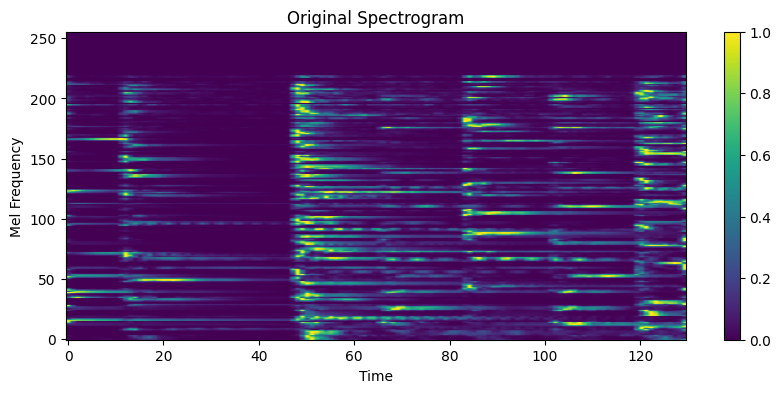

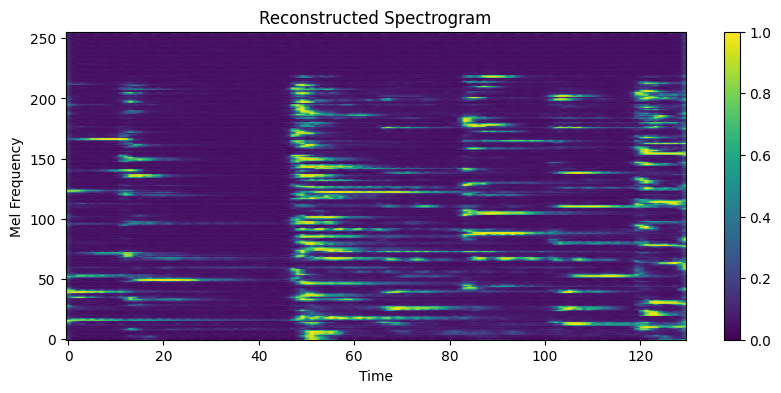

Training:  61%|██████    | 61/100 [02:02<01:29,  2.29s/epoch]

Epoch 60/100, Loss: 1425.9275, Lr: 0.0001


Training:  62%|██████▏   | 62/100 [02:04<01:25,  2.24s/epoch]

Epoch 61/100, Loss: 1430.6760, Lr: 0.0001


Training:  63%|██████▎   | 63/100 [02:06<01:21,  2.21s/epoch]

Epoch 62/100, Loss: 1423.8906, Lr: 0.0001


Training:  64%|██████▍   | 64/100 [02:08<01:18,  2.19s/epoch]

Epoch 63/100, Loss: 1421.4465, Lr: 0.0001


Training:  65%|██████▌   | 65/100 [02:10<01:16,  2.18s/epoch]

Epoch 64/100, Loss: 1412.0370, Lr: 0.0001


Training:  66%|██████▌   | 66/100 [02:12<01:13,  2.17s/epoch]

Epoch 65/100, Loss: 1409.4401, Lr: 0.0001


Training:  67%|██████▋   | 67/100 [02:15<01:11,  2.17s/epoch]

Epoch 66/100, Loss: 1409.3876, Lr: 0.0001


Training:  68%|██████▊   | 68/100 [02:17<01:09,  2.18s/epoch]

Epoch 67/100, Loss: 1412.1931, Lr: 0.0001


Training:  69%|██████▉   | 69/100 [02:19<01:07,  2.19s/epoch]

Epoch 68/100, Loss: 1410.3712, Lr: 0.0001
Epoch 69/100, Loss: 1399.9001, Lr: 0.0001


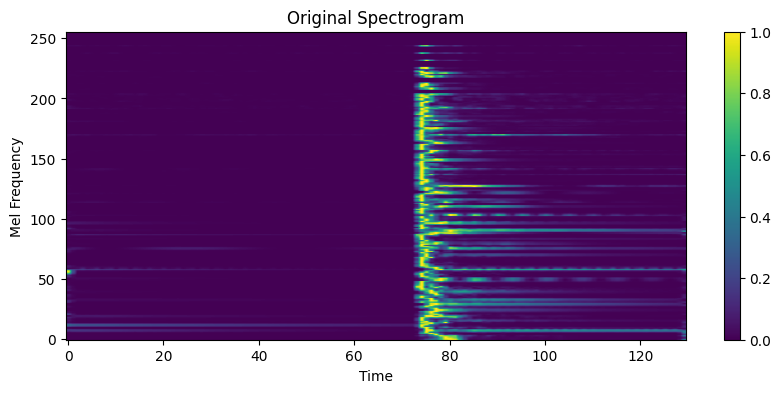

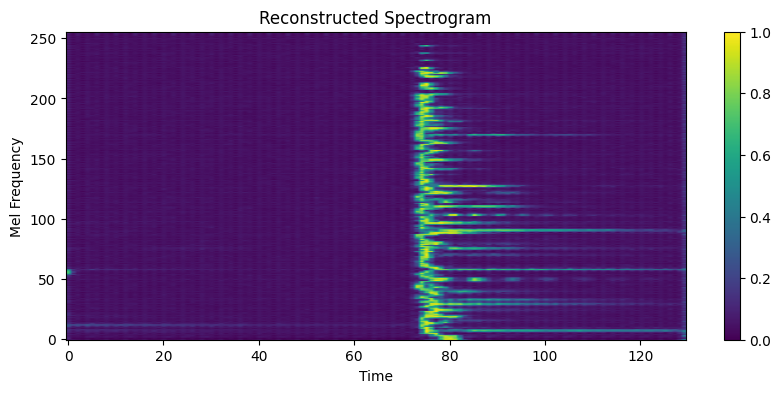

Training:  71%|███████   | 71/100 [02:24<01:07,  2.32s/epoch]

Epoch 70/100, Loss: 1398.7599, Lr: 0.0001


Training:  72%|███████▏  | 72/100 [02:26<01:04,  2.30s/epoch]

Epoch 71/100, Loss: 1403.4498, Lr: 0.0001


Training:  73%|███████▎  | 73/100 [02:29<01:01,  2.29s/epoch]

Epoch 72/100, Loss: 1421.5475, Lr: 0.0001


Training:  74%|███████▍  | 74/100 [02:31<00:59,  2.28s/epoch]

Epoch 73/100, Loss: 1406.4872, Lr: 0.0001


Training:  75%|███████▌  | 75/100 [02:33<00:57,  2.28s/epoch]

Epoch 74/100, Loss: 1418.7295, Lr: 0.0001


Training:  76%|███████▌  | 76/100 [02:35<00:54,  2.29s/epoch]

Epoch 75/100, Loss: 1395.8614, Lr: 0.0001


Training:  77%|███████▋  | 77/100 [02:38<00:52,  2.30s/epoch]

Epoch 76/100, Loss: 1414.2575, Lr: 0.0001


Training:  78%|███████▊  | 78/100 [02:40<00:50,  2.31s/epoch]

Epoch 77/100, Loss: 1401.3570, Lr: 0.0001


Training:  79%|███████▉  | 79/100 [02:42<00:48,  2.32s/epoch]

Epoch 78/100, Loss: 1404.9815, Lr: 0.0001
Epoch 79/100, Loss: 1391.9783, Lr: 0.0001


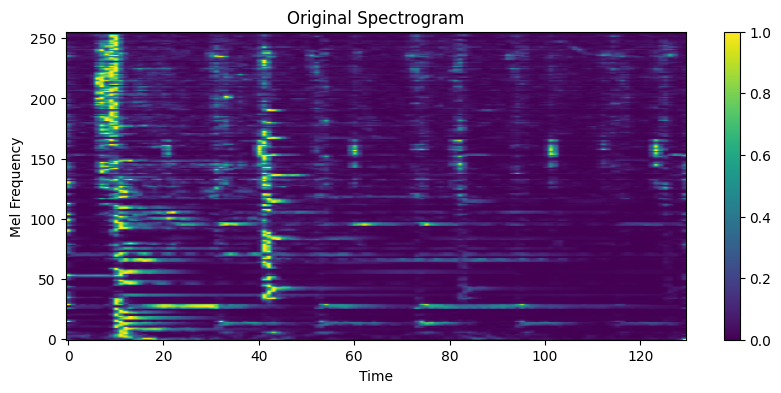

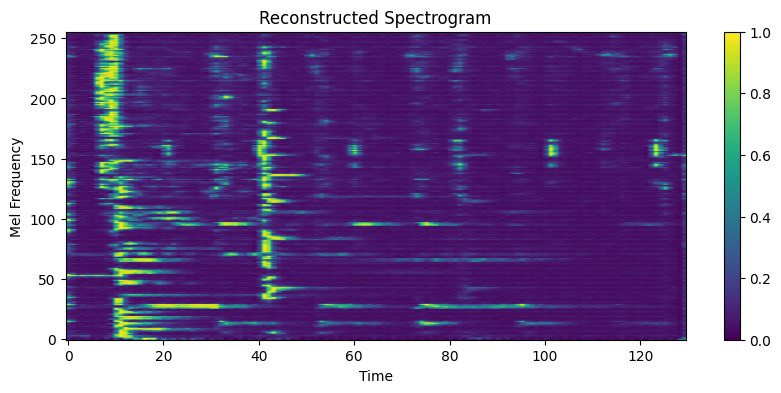

Training:  81%|████████  | 81/100 [02:48<00:46,  2.46s/epoch]

Epoch 80/100, Loss: 1403.9260, Lr: 0.0001


Training:  82%|████████▏ | 82/100 [02:50<00:43,  2.42s/epoch]

Epoch 81/100, Loss: 1412.7571, Lr: 0.0001


Training:  83%|████████▎ | 83/100 [02:52<00:40,  2.39s/epoch]

Epoch 82/100, Loss: 1394.7096, Lr: 0.0001


Training:  84%|████████▍ | 84/100 [02:55<00:37,  2.37s/epoch]

Epoch 83/100, Loss: 1408.5689, Lr: 0.0001


Training:  85%|████████▌ | 85/100 [02:57<00:35,  2.34s/epoch]

Epoch 84/100, Loss: 1394.7477, Lr: 0.0001


Training:  86%|████████▌ | 86/100 [02:59<00:32,  2.32s/epoch]

Epoch 85/100, Loss: 1385.3900, Lr: 0.0001


Training:  87%|████████▋ | 87/100 [03:01<00:29,  2.30s/epoch]

Epoch 86/100, Loss: 1395.9808, Lr: 0.0001


Training:  88%|████████▊ | 88/100 [03:04<00:27,  2.29s/epoch]

Epoch 87/100, Loss: 1401.6209, Lr: 0.0001


Training:  89%|████████▉ | 89/100 [03:06<00:24,  2.27s/epoch]

Epoch 88/100, Loss: 1382.0137, Lr: 0.0001
Epoch 89/100, Loss: 1380.3184, Lr: 0.0001


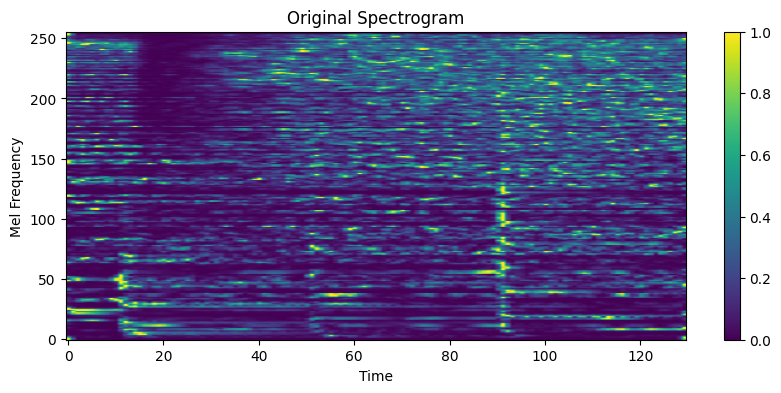

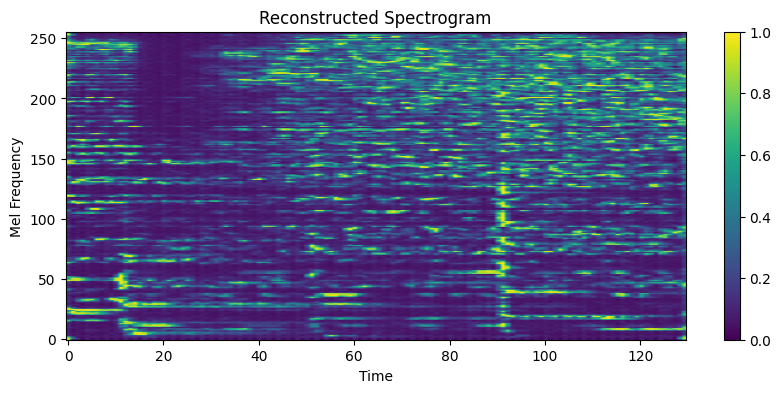

Training:  91%|█████████ | 91/100 [03:11<00:21,  2.38s/epoch]

Epoch 90/100, Loss: 1384.3106, Lr: 0.0001


Training:  92%|█████████▏| 92/100 [03:13<00:18,  2.33s/epoch]

Epoch 91/100, Loss: 1375.2572, Lr: 0.0001


Training:  93%|█████████▎| 93/100 [03:15<00:16,  2.29s/epoch]

Epoch 92/100, Loss: 1381.3659, Lr: 0.0001


Training:  94%|█████████▍| 94/100 [03:18<00:13,  2.27s/epoch]

Epoch 93/100, Loss: 1383.1111, Lr: 0.0001


Training:  95%|█████████▌| 95/100 [03:20<00:11,  2.25s/epoch]

Epoch 94/100, Loss: 1374.7277, Lr: 0.0001


Training:  96%|█████████▌| 96/100 [03:22<00:08,  2.23s/epoch]

Epoch 95/100, Loss: 1375.4178, Lr: 0.0001


Training:  97%|█████████▋| 97/100 [03:24<00:06,  2.23s/epoch]

Epoch 96/100, Loss: 1375.0457, Lr: 0.0001


Training:  98%|█████████▊| 98/100 [03:27<00:04,  2.23s/epoch]

Epoch 97/100, Loss: 1375.5906, Lr: 0.0001


Training:  99%|█████████▉| 99/100 [03:29<00:02,  2.22s/epoch]

Epoch 98/100, Loss: 1377.5416, Lr: 0.0001
Epoch 99/100, Loss: 1353.7664, Lr: 5e-05


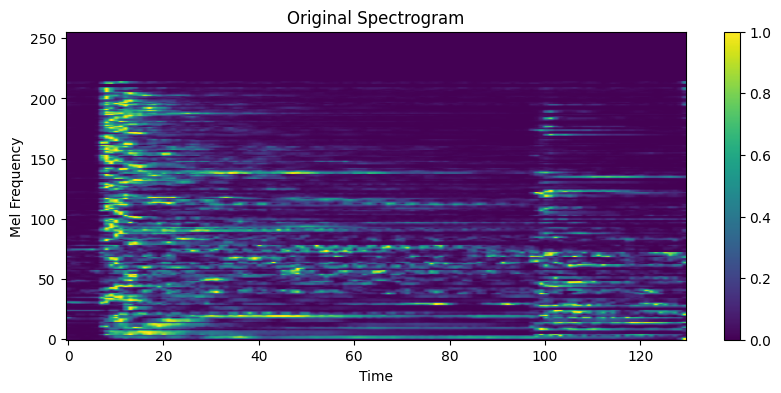

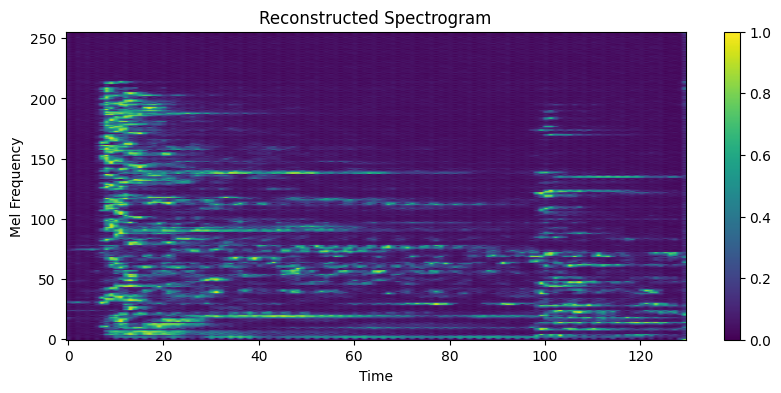

Training: 100%|██████████| 100/100 [03:32<00:00,  2.12s/epoch]


In [14]:
import torch.optim as optim

# Cấu hình tham số mô hình và huấn luyện
d_model = 64
latent_dim = 128
lr = 2e-4
num_epochs = 100
step_size = num_epochs // 2
verbose_interval = num_epochs // 10
gamma = 0.5

# Khởi tạo mô hình và chuyển sang thiết bị (CPU/GPU)
model = CVAE(d_model, latent_dim, n_mels, frame, max_genres).to(device)

# Tối ưu hóa và scheduler learning rate
optimizer = optim.AdamW(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.StepLR(
    optimizer, step_size=step_size, gamma=gamma)

# In tổng số tham số cần học
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params}")

# Huấn luyện mô hình
mu, logvar, losses = train_vae(
    model,
    trainloader,
    optimizer,
    scheduler,
    num_epochs,
    verbose_interval=verbose_interval
)

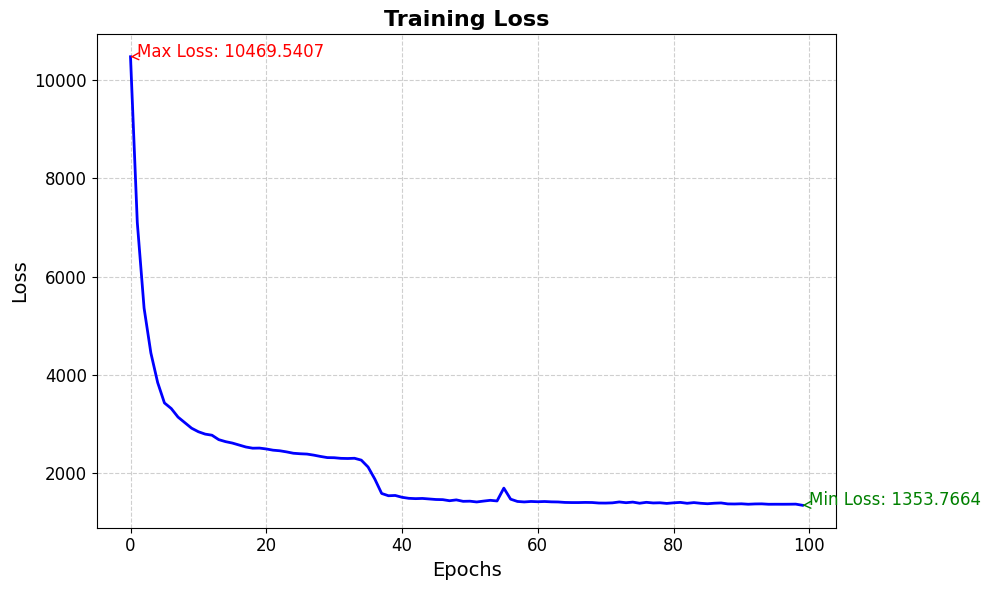

In [15]:
def plot_losses(losses, title="Training Loss", xlabel="Epochs", ylabel="Loss", color='b', grid=True):
    plt.figure(figsize=(10, 6))
    plt.plot(losses, color=color, linewidth=2)
    plt.title(title, fontsize=16, fontweight="bold")
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(grid, linestyle="--", alpha=0.6)

    min_loss_idx = losses.index(min(losses))
    max_loss_idx = losses.index(max(losses))

    plt.annotate(f"Min Loss: {min(losses):.4f}",
                 xy=(min_loss_idx, min(losses)),
                 xytext=(min_loss_idx + 1, min(losses) + 0.1),
                 arrowprops=dict(arrowstyle="->", color="green"),
                 fontsize=12, color='green')

    plt.annotate(f"Max Loss: {max(losses):.4f}",
                 xy=(max_loss_idx, max(losses)),
                 xytext=(max_loss_idx + 1, max(losses) + 0.1),
                 arrowprops=dict(arrowstyle="->", color="red"),
                 fontsize=12, color="red")

    plt.tight_layout()
    plt.show()


plot_losses(losses)

## Inferences

In [16]:
def inference(model, testloader):
    model.eval()
    with torch.no_grad():
        data, genres_input, ori_data = next(iter(testloader))
        data = data.to(device)
        genres_input = genres_input.to(device)
        recon, _, _ = model(data, genres_input)
        return recon, genres_input, ori_data

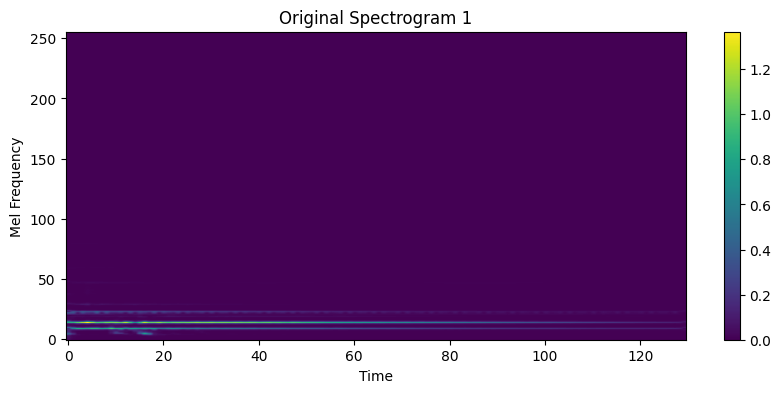

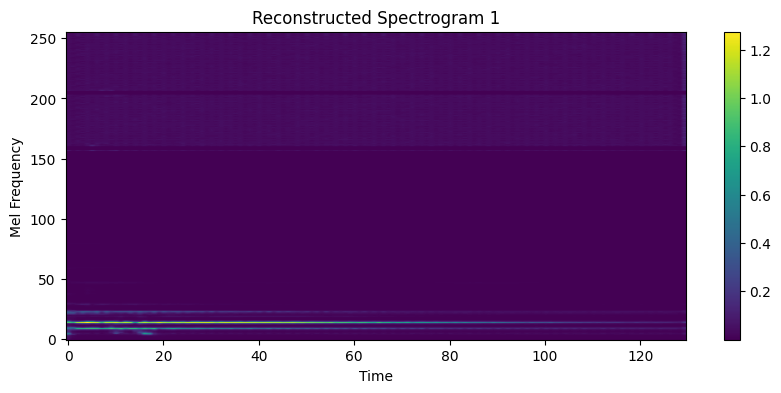

Original Audio:


Reconstructed Audio (from Mel Spectrogram):


----------------------------------------------------------------------------------------------------

Connect all original audio


Connect all reconstructed audio


In [17]:
gen_mels, genres_input, ori_data = inference(model, testloader)
recon_audios = []
ori_audios = []
num_samples = 5
for i in range(len(gen_mels[:num_samples])):
    show_spectrogram(
        ori_data[i], title=f"Original Spectrogram {i+1}", denormalize=True)
    ori_reconstructed = melspec_to_audio(
        ori_data[i].cpu().numpy().squeeze(), sample_rate)
    ori_audios.append(ori_reconstructed)

    spec_denorm = denormalize_melspec(
        gen_mels[i].cpu().numpy().squeeze(), ori_data[i].cpu().numpy().squeeze())
    show_spectrogram(
        spec_denorm, title=f"Reconstructed Spectrogram {i+1}", denormalize=True, is_numpy=True)
    audio_reconstructed = melspec_to_audio(spec_denorm, sample_rate)
    recon_audios.append(audio_reconstructed)

    display_audio_files(audio_reconstructed, sample_rate,
                        original_audio=ori_reconstructed)
    print("-" * 100, end="\n\n")

ori_audios = np.concatenate(ori_audios)
display_audio_files(ori_audios, sample_rate,
                    title="Connect all original audio")
recon_audios = np.concatenate(recon_audios)
display_audio_files(recon_audios, sample_rate,
                    title="Connect all reconstructed audio")